# Base Code

In [59]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from model.build_model import Build_Model
from model.loss.yolo_loss import YoloV4Loss
import torch.optim as optim
from torch.utils.data import DataLoader
import utils.datasets as data
from utils import cosine_lr_scheduler
import config.yolov4_config as cfg
import torch
from torch.utils.data import Dataset
from PIL import Image

# from dataset import BuildDataset

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10, 10

# from eval.evaluator import Evaluator
from collections import defaultdict

from utils.data_augment import *
from utils.tools import *
from utils.visualize import *

In [60]:
# GPU device
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cpu


In [61]:
start_epoch = 0
best_mAP = 0.0
epochs = 20
eval_epoch = 2
batch_size = 1

# weight_path = 'weight/mobilenetv2.pth'
weight_path = 'weight/yolov4.weights'

train_anno_path = './data/train_annotation.txt'

In [62]:
# # dataset
# import os
# import glob
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import matplotlib.patches as patches
# import torch
# from torch.utils.data import Dataset
# from PIL import Image
# import torchvision
# import cv2

# import random
# import pandas as pd
# import numpy as np

# import utils.datasets as data
# from utils import cosine_lr_scheduler
# import utils.data_augment as dataAug
# import utils.tools as tools
# import config.yolov4_config as cfg

# class BuildDataset(Dataset):
#     def __init__(self, path, img_size=416):
#         self.img_size = img_size
#         self.classes = ['1', '2', '3', '4', '5', '6']
#         self.num_classes = len(self.classes)
#         self.class_to_id = dict(zip(self.classes, range(self.num_classes)))
#         anno_path = path
#         with open(anno_path, "r") as f:
#             annotations = list(filter(lambda x: len(x) > 0, f.readlines()))
        
#         self.__annotations = annotations
        
#     def __len__(self):
#         return len(self.__annotations)
    
#     def __getitem__(self, item):
#         img_org, bboxes_org = self.__parse_annotation(self.__annotations[item])
#         img_org = img_org.transpose(2, 0, 1)  # HWC->CHW
        
#         # blur 같은 효과 부분
# #         item_mix = random.randint(0, len(self.__annotations) - 1)
# #         img_mix, bboxes_mix = self.__parse_annotation(
# #             self.__annotations[item_mix]
# #         )
# #         img_mix = img_mix.transpose(2, 0, 1)

# #         img, bboxes = dataAug.Mixup()(img_org, bboxes_org, img_mix, bboxes_mix)
# #         del img_org, bboxes_org, img_mix, bboxes_mix

#         img = img_org
#         bboxes = bboxes_org
        
#         (
#             label_sbbox,
#             label_mbbox,
#             label_lbbox,
#             sbboxes,
#             mbboxes,
#             lbboxes,
#         ) = self.__creat_label(bboxes)

#         img = torch.from_numpy(img).float()
#         label_sbbox = torch.from_numpy(label_sbbox).float()
#         label_mbbox = torch.from_numpy(label_mbbox).float()
#         label_lbbox = torch.from_numpy(label_lbbox).float()
#         sbboxes = torch.from_numpy(sbboxes).float()
#         mbboxes = torch.from_numpy(mbboxes).float()
#         lbboxes = torch.from_numpy(lbboxes).float()

#         return (
#             img,
#             label_sbbox,
#             label_mbbox,
#             label_lbbox,
#             sbboxes,
#             mbboxes,
#             lbboxes,
#         )
        
    
#     def __parse_annotation(self, annotation):
#         """
#         Data augument.
#         :param annotation: Image' path and bboxes' coordinates, categories.
#         ex. [image_path xmin,ymin,xmax,ymax,class_ind xmin,ymin,xmax,ymax,class_ind ...]
#         :return: Return the enhanced image and bboxes. bbox'shape is [xmin, ymin, xmax, ymax, class_ind]
#         """
#         anno = annotation.strip().split(" ")
# #         print("------------------------------------------------------")
# #         print(anno)

#         img_path = anno[0]
#         img = cv2.imread(img_path)  # H*W*C and C=BGR
#         assert img is not None, "File Not Found " + img_path
#         bboxes = np.array(
#             [list(map(float, box.split(","))) for box in anno[1:]]
#         )
# #         print(bboxes)

# #         img, bboxes = dataAug.RandomHorizontalFilp()(
# #             np.copy(img), np.copy(bboxes), img_path
# #         )
# #         img, bboxes = dataAug.RandomCrop()(np.copy(img), np.copy(bboxes))
# #         img, bboxes = dataAug.RandomAffine()(np.copy(img), np.copy(bboxes))
# #         img, bboxes = dataAug.Resize((self.img_size, self.img_size), True)(
# #             np.copy(img), np.copy(bboxes)
# #         )

#         return img, bboxes
    
#     def __creat_label(self, bboxes):
#         """
#         Label assignment. For a single picture all GT box bboxes are assigned anchor.
#         1、Select a bbox in order, convert its coordinates("xyxy") to "xywh"; and scale bbox'
#            xywh by the strides.
#         2、Calculate the iou between the each detection layer'anchors and the bbox in turn, and select the largest
#             anchor to predict the bbox.If the ious of all detection layers are smaller than 0.3, select the largest
#             of all detection layers' anchors to predict the bbox.

#         Note :
#         1、The same GT may be assigned to multiple anchors. And the anchors may be on the same or different layer.
#         2、The total number of bboxes may be more than it is, because the same GT may be assigned to multiple layers
#         of detection.

#         """

#         anchors = np.array(cfg.MODEL["ANCHORS"])
#         strides = np.array(cfg.MODEL["STRIDES"])
#         train_output_size = self.img_size / strides
#         anchors_per_scale = cfg.MODEL["ANCHORS_PER_SCLAE"]
        
# #         print("train_output_size: ", train_output_size)
# #         print("anchors_per_scale: ", anchors_per_scale)

#         label = [
#             np.zeros(
#                 (
#                     int(train_output_size[i]),
#                     int(train_output_size[i]),
#                     anchors_per_scale,
#                     6 + self.num_classes,
#                 )
#             )
#             for i in range(3)
#         ]
# #         print("len label: ", len(label))
# #         print(label[0].shape)
        
#         for i in range(3):
#             label[i][..., 5] = 1.0

#         bboxes_xywh = [
#             np.zeros((150, 4)) for _ in range(3)
#         ]  # Darknet the max_num is 30
#         bbox_count = np.zeros((3,))
        
# #         print("bboxes")
# #         print(bboxes)

#         for bbox in bboxes:
#             bbox_coor = bbox[:4]
#             bbox_class_ind = int(bbox[4])
#             bbox_mix = bbox[5]
# #             print(bbox_mix)

#             # onehot
#             one_hot = np.zeros(self.num_classes, dtype=np.float32)
#             one_hot[bbox_class_ind] = 1.0
# #             print("one hot: ", one_hot)
            
# #             one_hot_smooth = dataAug.LabelSmooth()(one_hot, self.num_classes)
# #             print(one_hot_smooth)

#             # convert "xyxy" to "xywh"
#             bbox_xywh = np.concatenate(
#                 [
#                     (bbox_coor[2:] + bbox_coor[:2]) * 0.5,
#                     bbox_coor[2:] - bbox_coor[:2],
#                 ],
#                 axis=-1,
#             )
#             # print("bbox_xywh: ", bbox_xywh)

#             bbox_xywh_scaled = (
#                 1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
#             )

#             iou = []
#             exist_positive = False
#             for i in range(3):
#                 anchors_xywh = np.zeros((anchors_per_scale, 4))
#                 anchors_xywh[:, 0:2] = (
#                     np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
#                 )  # 0.5 for compensation
#                 anchors_xywh[:, 2:4] = anchors[i]

#                 iou_scale = tools.iou_xywh_numpy(
#                     bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
#                 )
#                 iou.append(iou_scale)
#                 iou_mask = iou_scale > 0.3
# #                 print(iou_mask)

#                 if np.any(iou_mask):
#                     xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
#                         np.int32
#                     )

#                     # Bug : 当多个bbox对应同一个anchor时，默认将该anchor分配给最后一个bbox
#                     label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
#                     label[i][yind, xind, iou_mask, 4:5] = 1.0
#                     label[i][yind, xind, iou_mask, 5:6] = bbox_mix
#                     label[i][yind, xind, iou_mask, 6:] = one_hot

#                     bbox_ind = int(bbox_count[i] % 150)  # BUG : 150为一个先验值,内存消耗大
#                     bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
#                     bbox_count[i] += 1

#                     exist_positive = True

#             if not exist_positive:
#                 best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
#                 best_detect = int(best_anchor_ind / anchors_per_scale)
#                 best_anchor = int(best_anchor_ind % anchors_per_scale)

#                 xind, yind = np.floor(
#                     bbox_xywh_scaled[best_detect, 0:2]
#                 ).astype(np.int32)

#                 label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
#                 label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
#                 label[best_detect][yind, xind, best_anchor, 5:6] = bbox_mix
#                 label[best_detect][yind, xind, best_anchor, 6:] = one_hot

#                 bbox_ind = int(bbox_count[best_detect] % 150)
#                 bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
#                 bbox_count[best_detect] += 1
                
# #             print("len label", len(label))

#         label_sbbox, label_mbbox, label_lbbox = label
#         sbboxes, mbboxes, lbboxes = bboxes_xywh

#         return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

In [63]:
# coding=utf-8
import os
import sys

sys.path.append("..")
sys.path.append("../utils")
import torch
from torch.utils.data import Dataset, DataLoader
import config.yolov4_config as cfg
import cv2
import numpy as np
import random

# from . import data_augment as dataAug
# from . import tools

import utils.data_augment as dataAug
import utils.tools as tools


class Build_Dataset(Dataset):
    def __init__(self, anno_file_type, img_size=416):
        self.img_size = img_size  # For Multi-training
        if cfg.TRAIN["DATA_TYPE"] == "VOC":
            self.classes = cfg.VOC_DATA["CLASSES"]
        elif cfg.TRAIN["DATA_TYPE"] == "COCO":
            self.classes = cfg.COCO_DATA["CLASSES"]
        else:
            self.classes = cfg.Customer_DATA["CLASSES"]
        self.num_classes = len(self.classes)
        self.class_to_id = dict(zip(self.classes, range(self.num_classes)))
        self.__annotations = self.__load_annotations('train')

    def __len__(self):
        return len(self.__annotations)

    def __getitem__(self, item):
        assert item <= len(self), "index range error"

        img_org, bboxes_org = self.__parse_annotation(self.__annotations[item])
        img_org = img_org.transpose(2, 0, 1)  # HWC->CHW

        item_mix = random.randint(0, len(self.__annotations) - 1)
        img_mix, bboxes_mix = self.__parse_annotation(
            self.__annotations[item_mix]
        )
        img_mix = img_mix.transpose(2, 0, 1)

        img, bboxes = dataAug.Mixup()(img_org, bboxes_org, img_mix, bboxes_mix)
        del img_org, bboxes_org, img_mix, bboxes_mix

        (
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        ) = self.__creat_label(bboxes)

        img = torch.from_numpy(img).float()
        label_sbbox = torch.from_numpy(label_sbbox).float()
        label_mbbox = torch.from_numpy(label_mbbox).float()
        label_lbbox = torch.from_numpy(label_lbbox).float()
        sbboxes = torch.from_numpy(sbboxes).float()
        mbboxes = torch.from_numpy(mbboxes).float()
        lbboxes = torch.from_numpy(lbboxes).float()

        return (
            img,
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        )

    def __load_annotations(self, anno_type):

        assert anno_type in [
            "train",
            "test",
        ], "You must choice one of the 'train' or 'test' for anno_type parameter"
        anno_path = os.path.join(
            cfg.DATA_PATH, anno_type + "_annotation.txt"
        )
        with open(anno_path, "r") as f:
            annotations = list(filter(lambda x: len(x) > 0, f.readlines()))
        assert len(annotations) > 0, "No images found in {}".format(anno_path)

        return annotations

    def __parse_annotation(self, annotation):
        """
        Data augument.
        :param annotation: Image' path and bboxes' coordinates, categories.
        ex. [image_path xmin,ymin,xmax,ymax,class_ind xmin,ymin,xmax,ymax,class_ind ...]
        :return: Return the enhanced image and bboxes. bbox'shape is [xmin, ymin, xmax, ymax, class_ind]
        """
        anno = annotation.strip().split(" ")

        img_path = anno[0]
        img = cv2.imread(img_path)  # H*W*C and C=BGR
        assert img is not None, "File Not Found " + img_path
        bboxes = np.array(
            [list(map(float, box.split(","))) for box in anno[1:]]
        )

        img, bboxes = dataAug.RandomHorizontalFilp()(
            np.copy(img), np.copy(bboxes), img_path
        )
        img, bboxes = dataAug.RandomCrop()(np.copy(img), np.copy(bboxes))
        img, bboxes = dataAug.RandomAffine()(np.copy(img), np.copy(bboxes))
        img, bboxes = dataAug.Resize((self.img_size, self.img_size), True)(
            np.copy(img), np.copy(bboxes)
        )

        return img, bboxes

    def __creat_label(self, bboxes):
        """
        Label assignment. For a single picture all GT box bboxes are assigned anchor.
        1、Select a bbox in order, convert its coordinates("xyxy") to "xywh"; and scale bbox'
           xywh by the strides.
        2、Calculate the iou between the each detection layer'anchors and the bbox in turn, and select the largest
            anchor to predict the bbox.If the ious of all detection layers are smaller than 0.3, select the largest
            of all detection layers' anchors to predict the bbox.
        Note :
        1、The same GT may be assigned to multiple anchors. And the anchors may be on the same or different layer.
        2、The total number of bboxes may be more than it is, because the same GT may be assigned to multiple layers
        of detection.
        """

        anchors = np.array(cfg.MODEL["ANCHORS"])
        strides = np.array(cfg.MODEL["STRIDES"])
        train_output_size = self.img_size / strides
        anchors_per_scale = cfg.MODEL["ANCHORS_PER_SCLAE"]

        label = [
            np.zeros(
                (
                    int(train_output_size[i]),
                    int(train_output_size[i]),
                    anchors_per_scale,
                    6 + self.num_classes,
                )
            )
            for i in range(3)
        ]
        for i in range(3):
            label[i][..., 5] = 1.0

        bboxes_xywh = [
            np.zeros((150, 4)) for _ in range(3)
        ]  # Darknet the max_num is 30
        bbox_count = np.zeros((3,))

        for bbox in bboxes:
            bbox_coor = bbox[:4]
            bbox_class_ind = int(bbox[4])
            bbox_mix = bbox[5]
            
            # onehot
            one_hot = np.zeros(self.num_classes, dtype=np.float32)
            one_hot[bbox_class_ind-1] = 1.0
            one_hot_smooth = dataAug.LabelSmooth()(one_hot, self.num_classes)

            # convert "xyxy" to "xywh"
            bbox_xywh = np.concatenate(
                [
                    (bbox_coor[2:] + bbox_coor[:2]) * 0.5,
                    bbox_coor[2:] - bbox_coor[:2],
                ],
                axis=-1,
            )
            # print("bbox_xywh: ", bbox_xywh)

            bbox_xywh_scaled = (
                1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]
            )

            iou = []
            exist_positive = False
            for i in range(3):
                anchors_xywh = np.zeros((anchors_per_scale, 4))
                anchors_xywh[:, 0:2] = (
                    np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                )  # 0.5 for compensation
                anchors_xywh[:, 2:4] = anchors[i]

                iou_scale = tools.iou_xywh_numpy(
                    bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh
                )
                iou.append(iou_scale)
                iou_mask = iou_scale > 0.3

                if np.any(iou_mask):
                    xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(
                        np.int32
                    )

                    # Bug : 当多个bbox对应同一个anchor时，默认将该anchor分配给最后一个bbox
                    label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                    label[i][yind, xind, iou_mask, 4:5] = 1.0
                    label[i][yind, xind, iou_mask, 5:6] = bbox_mix
                    label[i][yind, xind, iou_mask, 6:] = one_hot_smooth

                    bbox_ind = int(bbox_count[i] % 150)  # BUG : 150为一个先验值,内存消耗大
                    bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                    bbox_count[i] += 1

                    exist_positive = True

            if not exist_positive:
                best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                best_detect = int(best_anchor_ind / anchors_per_scale)
                best_anchor = int(best_anchor_ind % anchors_per_scale)

                xind, yind = np.floor(
                    bbox_xywh_scaled[best_detect, 0:2]
                ).astype(np.int32)

                label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                label[best_detect][yind, xind, best_anchor, 5:6] = bbox_mix
                label[best_detect][yind, xind, best_anchor, 6:] = one_hot_smooth

                bbox_ind = int(bbox_count[best_detect] % 150)
                bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                bbox_count[best_detect] += 1

        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh

        return label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes

In [64]:
train_dataset = Build_Dataset(train_anno_path)

In [65]:
train_dataloader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            num_workers=0,
            shuffle=True,
            pin_memory=True,
        )

- image 확인하기

*************************
torch.Size([1, 3, 416, 416])
Shape: torch.Size([416, 416, 3])


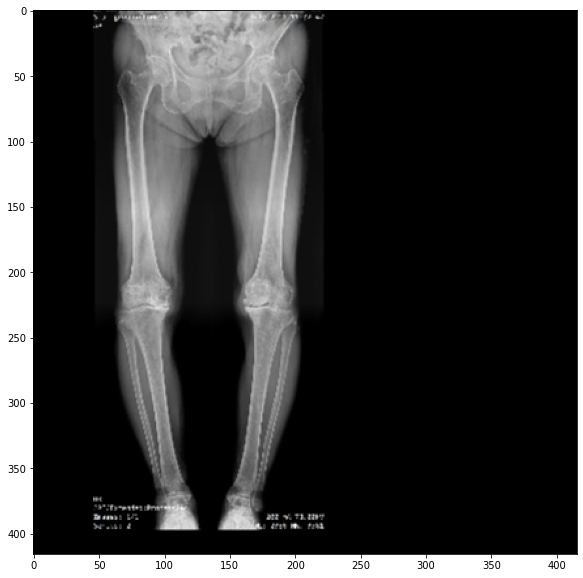

In [66]:
for i, (img, label_sbbox, label_mbbox, label_lbbox, sbboxes, mbboxes, lbboxes,) in enumerate(train_dataloader):
    print("*************************")
    print(img.shape)
    
    break

image = img.squeeze().permute(1, 2, 0)

print("Shape:", image.shape)
plt.imshow(image)
plt.show()

In [67]:
# model
yolov4 = Build_Model(weight_path=weight_path).to(device)

optimizer = optim.SGD(
            yolov4.parameters(),
            lr=cfg.TRAIN["LR_INIT"],
            momentum=cfg.TRAIN["MOMENTUM"],
            weight_decay=cfg.TRAIN["WEIGHT_DECAY"],
        )

criterion = YoloV4Loss(
            anchors=cfg.MODEL["ANCHORS"],
            strides=cfg.MODEL["STRIDES"],
            iou_threshold_loss=cfg.TRAIN["IOU_THRESHOLD_LOSS"],
        )

scheduler = cosine_lr_scheduler.CosineDecayLR(
            optimizer,
            T_max=epochs * len(train_dataloader),
            lr_init=cfg.TRAIN["LR_INIT"],
            lr_min=cfg.TRAIN["LR_END"],
            warmup=cfg.TRAIN["WARMUP_EPOCHS"] * len(train_dataloader),
        )

load darknet weights :  weight/yolov4.weights
loading weight BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
loading weight Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
loading weight BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
loading weight Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
loading weight BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
loading weight Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
loading weight BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
loading weight Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
loading weight BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
loading weight Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
loading weight BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [68]:
# Training
for epoch in range(start_epoch, epochs):
    yolov4.train()
    
    mloss = torch.zeros(4)
    for i, data in enumerate(train_dataloader):
        scheduler.step(len(train_dataloader) / (batch_size) * epoch + i)
        
        imgs = data[0]
        label_sbbox = data[1]
        label_mbbox = data[2]
        label_lbbox = data[3]
        sbboxes = data[4]
        mbboxes = data[5]
        lbboxes = data[6]
        
        imgs = imgs.to(device)
        label_sbbox = label_sbbox.to(device)
        label_mbbox = label_mbbox.to(device)
        label_lbbox = label_lbbox.to(device)
        sbboxes = sbboxes.to(device)
        mbboxes = mbboxes.to(device)
        lbboxes = lbboxes.to(device)
        
        p, p_d = yolov4(imgs)

        loss, loss_ciou, loss_conf, loss_cls = criterion(
            p,
            p_d,
            label_sbbox,
            label_mbbox,
            label_lbbox,
            sbboxes,
            mbboxes,
            lbboxes,
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_items = torch.tensor([loss_ciou, loss_conf, loss_cls, loss])
        mloss = (mloss * i + loss_items) / (i + 1)
        
        if i%10 == 0:
            print(f"Epoch: {epoch}/{epochs}, step: [{i}/{len(train_dataloader) - 1}], total_loss: {mloss[3]:.4f}, loss_ciou: {mloss[0]:.4f}, loss_conf: {mloss[1]:.4f}, loss_cls: {mloss[2]:.4f}")
            
        chkpt = {
            "epoch": epoch,
            # "best_mAP": self.best_mAP,
            "model": yolov4.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        torch.save(chkpt, f"model.pt")

Epoch: 0/20, step: [0/1624], total_loss: 2022.6447, loss_ciou: 21.2126, loss_conf: 1912.7786, loss_cls: 88.6534
Epoch: 0/20, step: [10/1624], total_loss: 2006.2266, loss_ciou: 22.1995, loss_conf: 1892.2384, loss_cls: 91.7886
Epoch: 0/20, step: [20/1624], total_loss: 1912.8932, loss_ciou: 21.7754, loss_conf: 1801.7338, loss_cls: 89.3840
Epoch: 0/20, step: [30/1624], total_loss: 1761.4756, loss_ciou: 21.5455, loss_conf: 1651.4066, loss_cls: 88.5233
Epoch: 0/20, step: [40/1624], total_loss: 1589.2151, loss_ciou: 21.5060, loss_conf: 1479.3510, loss_cls: 88.3576
Epoch: 0/20, step: [50/1624], total_loss: 1427.2573, loss_ciou: 21.4502, loss_conf: 1317.5000, loss_cls: 88.3069
Epoch: 0/20, step: [60/1624], total_loss: 1286.0194, loss_ciou: 21.3864, loss_conf: 1176.4542, loss_cls: 88.1786
Epoch: 0/20, step: [70/1624], total_loss: 1167.3030, loss_ciou: 21.4659, loss_conf: 1057.3975, loss_cls: 88.4392
Epoch: 0/20, step: [80/1624], total_loss: 1067.1763, loss_ciou: 21.3471, loss_conf: 957.7724, los

KeyboardInterrupt: 

In [ ]:
yolov4.parameters()

# Test

In [ ]:
yolov4 = Build_Model().to(device)

w_path = './chkpt/model_.pt'
chkpt = torch.load(os.path.join(w_path))
# chkpt = torch.load(os.path.join(w_path),  map_location=torch.device('cpu'))

yolov4.load_state_dict(chkpt['model'])

classes = ['1', '2', '3', '4', '5', '6']

In [4]:
class Evaluator(object):
    def __init__(self, model=None, showatt=False):
        self.classes = cfg.Customer_DATA["CLASSES"]
        self.conf_thresh = cfg.VAL["CONF_THRESH"]
        self.nms_thresh = cfg.VAL["NMS_THRESH"]
        self.val_shape = cfg.VAL["TEST_IMG_SIZE"]
        self.model = model
        self.device = next(model.parameters()).device
        self.visual_imgs = 0
        self.multi_scale_test = cfg.VAL["MULTI_SCALE_VAL"]
        self.flip_test = cfg.VAL["FLIP_VAL"]
        self.showatt = showatt
        self.inference_time = 0.0
        self.final_result = defaultdict(list)

    
    def get_bbox(self, img, multi_test=False, flip_test=False, mode=None):
        if multi_test:
            test_input_sizes = range(320, 640, 96)
            bboxes_list = []
            for test_input_size in test_input_sizes:
                valid_scale = (0, np.inf)
                bboxes_list.append(
                    self.__predict(img, test_input_size, valid_scale, mode)
                )
                if flip_test:
                    bboxes_flip = self.__predict(
                        img[:, ::-1], test_input_size, valid_scale, mode
                    )
                    bboxes_flip[:, [0, 2]] = (
                        img.shape[1] - bboxes_flip[:, [2, 0]]
                    )
                    bboxes_list.append(bboxes_flip)
            bboxes = np.row_stack(bboxes_list)
        else:
            bboxes = self.__predict(img, self.val_shape, (0, np.inf), mode)

        bboxes = nms(bboxes, self.conf_thresh, self.nms_thresh)

        return bboxes

    def __predict(self, img, test_shape, valid_scale, mode):
        org_img = np.copy(img)
        org_h, org_w, _ = org_img.shape

        img = self.__get_img_tensor(img, test_shape).to(self.device)
#         img = torch.from_numpy(img[np.newaxis, ...]).float().to(self.device)
    
        self.model.eval()
        with torch.no_grad():
#             start_time = current_milli_time()
            if self.showatt:
                _, p_d, atten = self.model(img)
            else:
                _, p_d = self.model(img)
#             self.inference_time += current_milli_time() - start_time
        pred_bbox = p_d.squeeze().cpu().numpy()
#         print(pred_bbox)
#         print(pred_bbox.shape)
#         print(pred_bbox.shape, test_shape, (org_h, org_w), valid_scale)
        bboxes = self.__convert_pred(
            pred_bbox, test_shape, (org_h, org_w), valid_scale
        )
#         if self.showatt and len(img) and mode == 'det':
#             self.__show_heatmap(atten, org_img)
#         print(bboxes)
#         print(bboxes.shape)
        return bboxes

    def __get_img_tensor(self, img, test_shape):
        img = Resize((test_shape, test_shape), correct_box=False)(
            img, None
        ).transpose(2, 0, 1)
        return torch.from_numpy(img[np.newaxis, ...]).float()

    def __convert_pred(
        self, pred_bbox, test_input_size, org_img_shape, valid_scale
        ):
        """
        Filter out the prediction box to remove the unreasonable scale of the box
        """
        pred_coor = xywh2xyxy(pred_bbox[:, :4])
#         pred_coor = pred_bbox[:, :4]
        pred_conf = pred_bbox[:, 4]
        pred_prob = pred_bbox[:, 5:]

        # (1)
        # (xmin_org, xmax_org) = ((xmin, xmax) - dw) / resize_ratio
        # (ymin_org, ymax_org) = ((ymin, ymax) - dh) / resize_ratio
        org_h, org_w = org_img_shape
        resize_ratio = min(
            1.0 * test_input_size / org_w, 1.0 * test_input_size / org_h
        )
#         print("resize ratio: ", resize_ratio)
        dw = (test_input_size - resize_ratio * org_w) / 2
        dh = (test_input_size - resize_ratio * org_h) / 2
        pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
        pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

        # (2)Crop off the portion of the predicted Bbox that is beyond the original image
        pred_coor = np.concatenate(
            [
                np.maximum(pred_coor[:, :2], [0, 0]),
                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1]),
            ],
            axis=-1,
        )
        # (3)Sets the coor of an invalid bbox to 0
        invalid_mask = np.logical_or(
            (pred_coor[:, 0] > pred_coor[:, 2]),
            (pred_coor[:, 1] > pred_coor[:, 3]),
        )
        pred_coor[invalid_mask] = 0

        # (4)Remove bboxes that are not in the valid range
        bboxes_scale = np.sqrt(
            np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1)
        )
        scale_mask = np.logical_and(
            (valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1])
        )

        # (5)Remove bboxes whose score is below the score_threshold
        classes = np.argmax(pred_prob, axis=-1)
        scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
        score_mask = scores > self.conf_thresh

        mask = np.logical_and(scale_mask, score_mask)

        coors = pred_coor[mask]
        scores = scores[mask]
        classes = classes[mask]

        bboxes = np.concatenate(
            [coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1
        )

        return bboxes

In [5]:
test_path = './data__/train/'
pred_path = './data__/pred/'

In [9]:
imgs_path = os.listdir(test_path)
imgs_path.sort()
n = len(imgs_path)

classes = ['1', '2', '3', '4', '5', '6']


for i, img_path in enumerate(imgs_path):
    path = os.path.join(test_path, img_path)
    img = cv2.imread(path)
    
#     img = torch.from_numpy(img)
#     print(img.shape)
    
    bboxes_prd = Evaluator(yolov4).get_bbox(img)
#     print("bboxes prd shape: ", bboxes_prd.shape)
    
    if bboxes_prd.shape[0] != 0:
        boxes = bboxes_prd[..., :4]
        class_inds = bboxes_prd[..., 5].astype(np.int32)
        scores = bboxes_prd[..., 4]
        print(boxes.shape)
        
        print(class_inds.shape)
        print(class_inds.count(0))
        
        print(len(scores))

        visualize_boxes(
            image=img,
            boxes=boxes,
            labels=class_inds,
            probs=scores,
            class_labels=classes,
        )
        
        print(img.shape)
        
        plt.imshow(img)

    break
    

(8515, 4)
(8515,)


AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [15]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


print(class_inds)

[0 0 0 ... 5 5 5]
